In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [3]:
train_losses = []

import inspectus
import inspectus.data_logger

step = 0
tracker = inspectus.data_logger.DataLogger('mnist')
tracker.clear()

In [4]:
def train(model, device, train_loader, optimizer, epoch):
    global step
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
        with torch.no_grad():
            tracker.save('train_loss', F.nll_loss(output, target, reduction='none'), step)
            step += 1
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [5]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [6]:
from torch.optim.lr_scheduler import StepLR

torch.manual_seed(1)

device = torch.device("mps")

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

dataset1 = datasets.MNIST('../data', train=True, download=True,
                   transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                   transform=transform)

train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=64, shuffle=False)

model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=0.05)

for epoch in range(1, 2):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

torch.save(model.state_dict(), "mnist_cnn.pt")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.306055
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.580686
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.305781
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.380577
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.290491
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.355984
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.276714
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.191841
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.193744
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.196256

Test set: Average loss: 0.1206, Accuracy: 9623/10000 (96%)



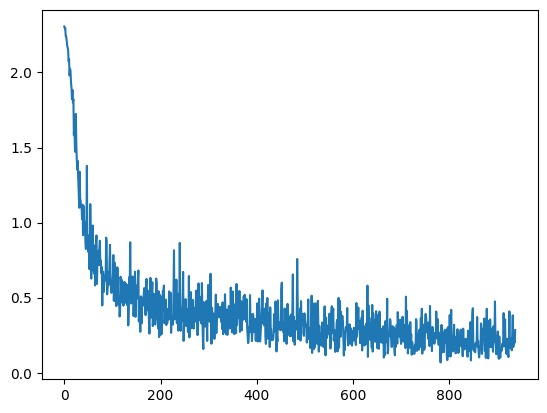

In [7]:
import matplotlib.pyplot as plt

plt.plot(train_losses)

In [8]:
tl = tracker.read('train_loss')
inspectus.distribution([tl], ["training loss"], height=500, width=500, height_minimap=100)

alt.VConcatChart(...)